In [1]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchtext.vocab import GloVe
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(66)

!cp /content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/mp2_release/scripts/evaluate.py /content/
!cp /content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/mp2_release/scripts/state.py /content/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def dim(a):
    if not type(a) == list:
        return []
    return [len(a)] + dim(a[0])

#State.py

In [3]:
from typing import List, Set

class Token:
    def __init__(self, idx: int, word: str, pos: str):
        self.idx = idx # Unique index of the token
        self.word = word # Token string
        self.pos  = pos # Part of speech tag

class DependencyEdge:
    def __init__(self, source: Token, target: Token, label:str):
        self.source = source  # Source token index
        self.target = target  # target token index
        self.label  = label  # dependency label
        pass


class ParseState:
    def __init__(self, stack: List[Token], parse_buffer: List[Token], dependencies: List[DependencyEdge]):
        self.stack = stack # A stack of token indices in the sentence. Assumption: the root token has index 0, the rest of the tokens in the sentence starts with 1.
        self.parse_buffer = parse_buffer  # A buffer of token indices
        self.dependencies = dependencies
        pass

    def add_dependency(self, source_token, target_token, label):
        self.dependencies.append(
            DependencyEdge(
                source=source_token,
                target=target_token,
                label=label,
            )
        )

def shift(state: ParseState) -> None:
    # TODO: Implement this as an in-place operation that updates the parse state and does not return anything

    # The python documentation has some pointers on how lists can be used as stacks and queues. This may come useful:
    # https://docs.python.org/3/tutorial/datastructures.html#using-lists-as-stacks
    # https://docs.python.org/3/tutorial/datastructures.html#using-lists-as-queues

    a = state.parse_buffer.pop(0)
    state.stack.append(a)
    pass


def left_arc(state: ParseState, label: str) -> None:
    # TODO: Implement this as an in-place operation that updates the parse state and does not return anything

    # The python documentation has some pointers on how lists can be used as stacks and queues. This may come useful:
    # https://docs.python.org/3/tutorial/datastructures.html#using-lists-as-stacks
    # https://docs.python.org/3/tutorial/datastructures.html#using-lists-as-queues
    # Also, you will need to use the state.add_dependency method defined above.
    a = state.stack.pop()
    b = state.stack.pop()
    state.add_dependency(a, b, label)
    state.stack.append(a)
    pass


def right_arc(state: ParseState, label: str) -> None:
    # TODO: Implement this as an in-place operation that updates the parse state and does not return anything

    # The python documentation has some pointers on how lists can be used as stacks and queues. This may come useful:
    # https://docs.python.org/3/tutorial/datastructures.html#using-lists-as-stacks
    # https://docs.python.org/3/tutorial/datastructures.html#using-lists-as-queues
    # Also, you will need to use the state.add_dependency method defined above.
    a = state.stack.pop()
    b = state.stack.pop()
    state.add_dependency(b, a, label)
    state.stack.append(b)
    pass



def is_final_state(state: ParseState, cwindow: int) -> bool:
    # TODO: Implemement this
    # temp_word = [state.stack[i].word for i in range(len(state.stack))]
    # print(temp_word)
    if len(state.stack) == cwindow+1 and len(state.parse_buffer) == cwindow:
      return True
    else:
      return False
    pass


#Evaluate.py

In [5]:
def get_deps(words_lists, actions, cwindow):
    """ Computes all the dependencies set for all the sentences according to
    actions provided
    Inputs
    -----------
    words_lists: List[List[str]].  This is a list of lists. Each inner list is a list of words in a sentence,
    actions: List[List[str]]. This is a list of lists where each inner list is the sequence of actions
                Note that the elements should be valid actions as in `tagset.txt`
    cwindow: int. Context window. Default=2
    """
    all_deps = []   # List of List of dependencies
    # Iterate over sentences
    for w_ix, words_list in enumerate(words_lists):
        # Intialize stack and buffer appropriately
        stack = [Token(idx=-i-1, word="[NULL]", pos="NULL") for i in range(cwindow)]
        parser_buff = []
        for ix in range(len(words_list)):
            parser_buff.append(Token(idx=ix, word=words_list[ix], pos="NULL"))
        parser_buff.extend([Token(idx=ix+i+1, word="[NULL]",pos="NULL") for i in range(cwindow)])
        # Initilaze the parse state
        state = ParseState(stack=stack, parse_buffer=parser_buff, dependencies=[])

        # Iterate over the actions and do the necessary state changes
        for action in actions[w_ix]:
            if action == "SHIFT":
                shift(state)
            elif action[:8] == "REDUCE_L":
                left_arc(state, action[9:])
            else:
                right_arc(state, action[9:])
        assert is_final_state(state,cwindow)    # Check to see that the parse is complete
        right_arc(state, "root")    # Add te root dependency for the remaining element on stack
        all_deps.append(state.dependencies.copy())  # Copy over the dependenices found
    return all_deps




def compute_metrics(words_lists, gold_actions, pred_actions, cwindow=2):
    """ Computes the UAS and LAS metrics given list of words, gold and predicted actions.
    Inputs
    -------
    word_lists: List[List[str]]. This is a list of lists. Each inner list is a list of words in a sentence,
    gold_action: List[List[str]]. This is a list of lists where each inner list is the sequence of gold actions
                Note that the elements should be valid actions as in `tagset.txt`
    pred_action: List[List[str]]. This is a list of lists where each inner list is the sequence of predicted actions
                Note that the elements should be valid actions as in `tagset.txt`

    Outputs
    -------
    uas: int. The Unlabeled Attachment Score
    las: int. The Lableled Attachment Score
    """
    lab_match = 0  # Counter for computing correct head assignment and dep label
    unlab_match = 0 # Counter for computing correct head assignments
    total = 0       # Total tokens

    # Get all the dependencies for all the sentences
    gold_deps = get_deps(words_lists, gold_actions, cwindow)    # Dep according to gold actions
    pred_deps = get_deps(words_lists, pred_actions, cwindow)    # Dep according to predicted actions

    # Iterate over sentences
    for w_ix, words_list in enumerate(words_lists):
        # Iterate over words in a sentence
        for ix, word in enumerate(words_list):
            # Check what is the head of the word in the gold dependencies and its label
            for dep in gold_deps[w_ix]:
                if dep.target.idx == ix:
                    gold_head_ix = dep.source.idx
                    gold_label = dep.label
                    break
            # Check what is the head of the word in the predicted dependencies and its label
            for dep in pred_deps[w_ix]:
                if dep.target.idx == ix:
                    # Do the gold and predicted head match?
                    if dep.source.idx == gold_head_ix:
                        unlab_match += 1
                        # Does the label match?
                        if dep.label == gold_label:
                            lab_match += 1
                    break
            total += 1

    return unlab_match/total, lab_match/total

#Read File to Dictionary

In [6]:
def extract_to_dic(path_to_file):
  file1 = open(path_to_file, 'r')
  dictionary={}

  for index, line in enumerate(file1):
    dictionary[line.strip()] = index

  file1.close()
  return dictionary


#Download All GloVe

In [7]:
import torchtext.vocab as vocab
vec6B50D = vocab.GloVe(name='6B', dim=50)
# vec6B300D = vocab.GloVe(name='6B', dim=300)
# vec42B300D = vocab.GloVe(name='42B', dim=300)

In [7]:
vec840B300D = vocab.GloVe(name='840B', dim=300)

.vector_cache/glove.840B.300d.zip: 2.18GB [06:53, 5.27MB/s]                            
100%|█████████▉| 2196016/2196017 [05:41<00:00, 6427.42it/s]


#Read A File and convert it to a list

In [8]:
def read_file_to_list(path_to_file, has_action = True):
  file1 = open(path_to_file, 'r')
  Lines = file1.readlines()

  count = 0

  file_words = []
  file_pos = []
  file_target = []

  for line in Lines:
    count += 1
    line1 = line.strip()
    line2 = line1.split('|||')
    line_words = line2[0].lower().strip().split(' ')
    file_words.append(line_words)
    line_pos = line2[1].strip().split(' ')
    file_pos.append(line_pos)
    if has_action == True:
      line_action = line2[2].strip().split(' ')
      file_target.append(line_action)

  if has_action == False:
    return file_words, file_pos
  else:
    return file_words, file_pos, file_target


In [9]:
train_file = '/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/mp2_release/data/train.txt'
dev_file = '/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/mp2_release/data/dev.txt'
test_file = '/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/mp2_release/data/test.txt'
hidden_file = '/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/mp2_release/data/hidden.txt'

train_w, train_pos, train_target = read_file_to_list(train_file)
dev_w, dev_pos, dev_target = read_file_to_list(dev_file)
test_w, test_pos, test_target = read_file_to_list(test_file)
hidden_w, hidden_pos = read_file_to_list(hidden_file, False)

In [10]:
pos_file = '/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/mp2_release/data/pos_set.txt'
targets_file = '/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/mp2_release/data/tagset.txt'

pos_dict = extract_to_dic(pos_file)
targets_dict = extract_to_dic(targets_file)

#Set Mean/concatenate and cwindow

In [11]:
mean_mode = 1 #1 for mean, 0 for concatenate
cwindow = 2

#stoi() and target_itos()

In [12]:
def stoi(key, word2ix):
  isKeyPresent = key in word2ix
  if isKeyPresent == True:
    return word2ix[key]
  else:
    print(key)
    return word2ix['NULL']

key_list = list(targets_dict.keys())
val_list = list(targets_dict.values())
def target_itos(a):
  return key_list[a]

#Convert POS and Target to integer values

In [13]:
def convert_pos_to_token(train_pos, pos_dict):
  test_train_pos = []
  for i in range(0, len(train_pos)):
    # print(i)
    test_train_pos.append(list(map(lambda x: stoi(x,pos_dict), train_pos[i])))
  return test_train_pos

In [14]:
def convert_target_to_token(train_pos, pos_dict):
  test_train_pos = list(map(lambda x: stoi(x,pos_dict), train_pos))
  return test_train_pos

#Prepare Train Corpus

In [15]:
def embed_to_glove(train_w, vec, embed_dim,  mean, cwindow):
  print(mean)
  glove = vec
  embedded_text = torch.zeros((len(train_w), (2 * cwindow), embed_dim))
  for i in range(0,len(train_w)):
    # print(len(train_w[i]))
    temp_emb = glove.get_vecs_by_tokens(train_w[i])
    # print(temp_emb.shape)
    embedded_text[i] = temp_emb

    # if(i%10000 == 0):
    #   print(i)
  if mean==1:
    embedded_text = torch.mean(embedded_text, dim=1)
  else:
    embedded_text = embedded_text.view(embedded_text.size()[0], -1)

  return embedded_text


In [16]:
def prepare_train_corpus(list_words, list_pos, list_action, vec, embed_dim, mean_mode, cwindow):
  all_words = []
  all_pos = []
  all_target = []

  for x in range(len(list_words)):
    line_words = list_words[x]
    line_pos = list_pos[x]
    line_action = list_action[x]
    stack = [Token(idx=-i-1, word="[NULL]", pos='NULL') for i in range(cwindow)]
    parser_buff = []
    for ix in range(len(line_words)):
      parser_buff.append(Token(idx=ix, word=line_words[ix], pos=line_pos[ix]))
    parser_buff.extend([Token(idx=ix+i+1, word='NULL',pos="NULL") for i in range(cwindow)])
    state = ParseState(stack=stack, parse_buffer=parser_buff, dependencies=[])
    for action in line_action:
      temp_word = [state.stack[-i-1].word for i in range(cwindow)]
      temp_pos = [state.stack[-i-1].pos for i in range(cwindow)]

      temp_word.extend([state.parse_buffer[i].word for i in range(cwindow)])
      temp_pos.extend([state.parse_buffer[i].pos for i in range(cwindow)])

      all_words.append(temp_word)
      all_pos.append(temp_pos)
      all_target.append(action)

      if action == "SHIFT":
        shift(state)
      elif action[:8] == "REDUCE_L":
        left_arc(state, action[9:])
      else:
        right_arc(state, action[9:])
  # print(len(all_words[0]))
  X_train = torch.cat((embed_to_glove(all_words, vec, embed_dim, mean_mode, cwindow),torch.tensor(convert_pos_to_token(all_pos, pos_dict))), -1)
  y_train = torch.tensor(convert_target_to_token(all_target, targets_dict))

  return X_train, y_train


In [17]:
#Set glove and embedding dimenaion
# vec = vec6B50D
# embed_dim = 50

In [18]:
# X_train, y_train = prepare_train_corpus(train_w, train_pos, train_target, vec, embed_dim, mean_mode, cwindow)

In [17]:
dev_pos, test_pos, hidden_pos = convert_pos_to_token(dev_pos, pos_dict), convert_pos_to_token(test_pos, pos_dict), convert_pos_to_token(hidden_pos, pos_dict)

In [18]:
dev_target_t, test_target_t = convert_pos_to_token(dev_target, targets_dict), convert_pos_to_token(test_target, targets_dict)

#Model Description

In [19]:
class Parser_Model(nn.Module):
  def __init__(self, pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size):
    # , embed_max_norm
    super(Parser_Model, self).__init__()
    self.embeddings = nn.Embedding(
        num_embeddings= pos_vocab_size,
        embedding_dim= pos_embedding_dimension,
        max_norm= 1,
        )
    self.linear1 = nn.Linear(
        in_features= pos_embedding_dimension,
        out_features= hidden_dim,
        )
    self.linear2 = nn.Linear(
        in_features= glove_embedding_dimension,
        out_features= hidden_dim,
        )
    self.linear3 = nn.Linear(
        in_features= hidden_dim,
        out_features= action_vocab_size,
        )
    self.relu = torch.nn.ReLU()
  def forward(self, inputs_):
    x_w = inputs_[:,:-4]
    x_pos = inputs_[:,-4:].to(torch.int32)
    x_pos = self.embeddings(x_pos)
    x_pos = torch.mean(x_pos, dim=1)
    x1 = self.linear1(x_pos)
    x2 = self.linear2(x_w)
    x2 = x2 + x1
    x = self.linear3(self.relu(x2))
    return x

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#Batch_GD

In [21]:
print("Dunno")

Dunno


In [22]:
def batch_gd(model, criterion, optimizer, train_loader, dev_words, dev_pos, dev_actions, epochs, glove, glv_size, glv_dim, lr, mean_mode):
  train_losses = np.zeros(epochs)
  # dev_losses = np.zeros(epochs)
  best_acc = -1
  for i in range(epochs):
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      # outputs = outputs.to('cpu')
      # outputs = outputs.detach().numpy()
      # outputs = np.argmax(outputs, axis = 1)
      # print("outputs=",outputs)
      # print("Targets=",targets)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    train_losses[i] = train_loss
    print('Epoch = ', i, ' Train Loss = ',train_loss)

    dev_pred_actions = []
    for k in range(len(dev_words)):
      # if k % 5000 == 0:
      #   print("For Data = ", k)
      stack = [Token(idx=-j-1, word="[NULL]", pos= pos_dict['NULL']) for j in range(cwindow)]
      parser_buff = []
      dev_dependencies =[]
      for ix in range(len(dev_words[k])):
        parser_buff.append(Token(idx=ix, word=dev_words[k][ix], pos=dev_pos[k][ix]))
      parser_buff.extend([Token(idx=ix+j+1, word="[NULL]",pos= pos_dict['NULL']) for j in range(cwindow)])
      state = ParseState(stack=stack, parse_buffer=parser_buff, dependencies=[])
      m = 0
      dev_temp_action = []
      while(not is_final_state(state,cwindow)):
        dev_input=[]
        # print("Stack len = :", len(stack), len(parser_buff))
        dev_input.append(stack[-1].word)
        dev_input.append(stack[-2].word)
        dev_input.append(parser_buff[0].word)
        dev_input.append(parser_buff[1].word)
        dev_input.append(stack[-1].pos)
        dev_input.append(stack[-2].pos)
        dev_input.append(parser_buff[0].pos)
        dev_input.append(parser_buff[1].pos)

        temp_emb = glove.get_vecs_by_tokens(dev_input[:4])
        if mean_mode==1:
          temp_emb = torch.mean(temp_emb, dim=0)
        else:
          temp_emb = torch.flatten(temp_emb)
        # print(temp_emb.shape)
        # print(dev_input)
        temp_pos = torch.tensor(dev_input[4:])
        # print(temp_pos.shape)
        # print(temp_emb.shape)
        # print(temp_pos.shape)
        temp_input = torch.cat((temp_emb, temp_pos)).unsqueeze(0).to(device)
        # print(temp_input)
        outputs = model(temp_input)
        # print('Outputs = ',outputs.shape)
        _, predictions = torch.max(outputs, 1)
        # print('predictions = ',predictions)
        pred_action = target_itos(predictions[0])

        if len(stack) == 2 and predictions[0] != 0:
          pred_action = "SHIFT"
        elif len(parser_buff) == 2 and predictions[0] == 0:
          outputs[0][0] = -1000000
          _, predictions = torch.max(outputs, 1)
          pred_action = target_itos(predictions[0])

        # print('predictions = ',pred_action)

        dev_temp_action.append(pred_action)
        if pred_action == "SHIFT":
          shift(state)
        elif pred_action[:8] == "REDUCE_L":
          left_arc(state, pred_action[9:])
        else:
          right_arc(state, pred_action[9:])
      dev_pred_actions.append(dev_temp_action)

    dev_uas, dev_las = compute_metrics(dev_words, dev_actions, dev_pred_actions, cwindow=2)
    print("UAS,LAS = ",dev_uas, dev_las)
    if dev_uas > best_acc:
      best_acc = dev_uas
      torch.save({
          "model_param": model.state_dict(),
          "optim_param": optimizer.state_dict(),
          "lowest_dev_loss": best_acc,
          "epoch": i,
          "learning_rate": lr},
                 f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth")

  print("Best dev acc = ", best_acc)
  return train_losses, model, best_acc


#Training

##6B50D Mean

For learning rate =  0.01
Epoch =  0  Train Loss =  1.368352864848572
UAS,LAS =  0.31974622424344507 0.24282746617258996
Epoch =  1  Train Loss =  1.2853317854937099
UAS,LAS =  0.3245185559485711 0.25624614002582674
Epoch =  2  Train Loss =  1.2712838403495477
UAS,LAS =  0.32878558194374263 0.24861040929762507
Epoch =  3  Train Loss =  1.2652983754932525
UAS,LAS =  0.3322104317556566 0.2638818707540284
Epoch =  4  Train Loss =  1.263407086290671
UAS,LAS =  0.3429902869013531 0.26960866880017964
Epoch =  5  Train Loss =  1.2639384713712671
UAS,LAS =  0.345404525293358 0.2716860367188816
Epoch =  6  Train Loss =  1.261420988013031
UAS,LAS =  0.3238448150019651 0.2523159845039582
Epoch =  7  Train Loss =  1.2618233329851631
UAS,LAS =  0.3269889394194599 0.2574251866823873
Epoch =  8  Train Loss =  1.2615959370142187
UAS,LAS =  0.32957161304811633 0.25501094829038234
Epoch =  9  Train Loss =  1.2633437106819085
UAS,LAS =  0.3489416652630397 0.2748863062152602
Epoch =  10  Train Loss =  1.2

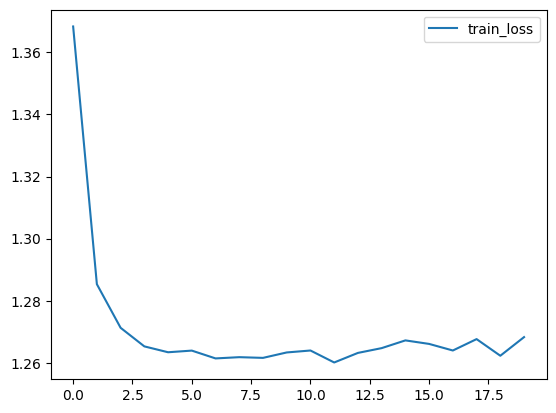

For learning rate =  0.001
Epoch =  0  Train Loss =  1.4512193386052286
UAS,LAS =  0.3198585144012127 0.24591544551120095
Epoch =  1  Train Loss =  1.2156299939508703
UAS,LAS =  0.37246645331536693 0.29605300095446635
Epoch =  2  Train Loss =  1.165966999748533
UAS,LAS =  0.3846499354331593 0.30812419291449106
Epoch =  3  Train Loss =  1.1387009139637467
UAS,LAS =  0.3892538319016338 0.3128965246196171
Epoch =  4  Train Loss =  1.1206659437721933
UAS,LAS =  0.3920610858458256 0.31823030711358147
Epoch =  5  Train Loss =  1.107507194723808
UAS,LAS =  0.39509292010555275 0.32193588231991466
Epoch =  6  Train Loss =  1.097536766579445
UAS,LAS =  0.39790017404974454 0.3262029083150862
Epoch =  7  Train Loss =  1.0893736093214326
UAS,LAS =  0.3980124642075122 0.32569760260513164
Epoch =  8  Train Loss =  1.0824259168525814
UAS,LAS =  0.3979563191286284 0.32362023468642975
Epoch =  9  Train Loss =  1.0764051211357235
UAS,LAS =  0.3970018527876032 0.3235640896075459
Epoch =  10  Train Loss = 

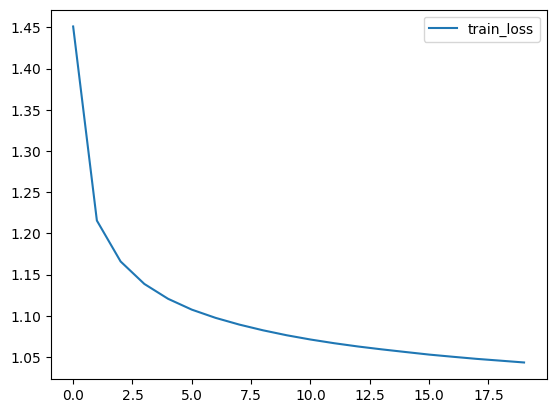

For learning rate =  0.0001
Epoch =  0  Train Loss =  2.0902398070450094
UAS,LAS =  0.21234068833866712 0.13384986805906463
Epoch =  1  Train Loss =  1.6382826753034743
UAS,LAS =  0.2623659536241648 0.18432429397563305
Epoch =  2  Train Loss =  1.5051476761372853
UAS,LAS =  0.27746897984391666 0.20111167256189996
Epoch =  3  Train Loss =  1.4330220891988539
UAS,LAS =  0.28162371568132055 0.20942114423670766
Epoch =  4  Train Loss =  1.3809410983004105
UAS,LAS =  0.29049463814496657 0.21913424288361125
Epoch =  5  Train Loss =  1.3413008899089118
UAS,LAS =  0.3014429285273146 0.23114928976475213
Epoch =  6  Train Loss =  1.310723468335438
UAS,LAS =  0.31637751951041493 0.24378193251361518
Epoch =  7  Train Loss =  1.2866743517443389
UAS,LAS =  0.3262029083150862 0.25254056481949355
Epoch =  8  Train Loss =  1.2673553247041778
UAS,LAS =  0.3359721520408736 0.26270282409746787
Epoch =  9  Train Loss =  1.2514852942013834
UAS,LAS =  0.3426534164280501 0.27067542529897254
Epoch =  10  Train

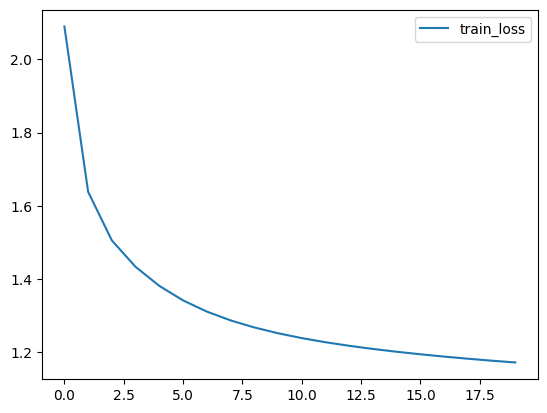

In [ ]:
glv_size = '6B'
glv_dim = 50
mean_mode = 1 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

train_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=False, batch_size=64)

# train_dataloader, dev_dataloader, test_dataloader, glove_embedding_dimension = prepare_dataset(glv_size, glv_dim, mean_mode, cwindow)

learning_rates = np.array([0.01, 0.001, 0.0001])
best_acc = -1

for i in range(learning_rates.shape[0]):
  pos_vocab_size = len(pos_dict)
  pos_embedding_dimension = 50
  # glove_embedding_dimension = X_train.shape[1] - 4
  # print(glove_embedding_dimension)
  hidden_dim = 200
  action_vocab_size = len(targets_dict)
  epoch = 20


  parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
  parser_model.to(device)
  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(parser_model.parameters(), lr=learning_rates[i])
  print("For learning rate = ",learning_rates[i])

  train_losses, ret_model, best_dev_acc = batch_gd(
      parser_model, criterion, optimizer, train_dataloader, dev_w, dev_pos, dev_target, epoch, vec6B50D, glv_size, glv_dim, learning_rates[i], mean_mode)


  # avg_dev_losses = np.mean(dev_losses)
  # print('Best Development Loss = ', best_dev_loss)


  plt.plot(train_losses, label = 'train_loss')
  # plt.plot(dev_losses, label = 'dev_loss')
  plt.legend()
  plt.show()

In [ ]:
pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

Best Dev Accuracy =  0.3952052102633204
Learning Rate =  0.0001
Epoch =  19


Parser_Model(
  (embeddings): Embedding(18, 50, max_norm=1)
  (linear1): Linear(in_features=50, out_features=200, bias=True)
  (linear2): Linear(in_features=50, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=75, bias=True)
  (relu): ReLU()
)

##6B50D Concatenate

In [ ]:
#Set glove and embedding dimenaion
vec = vec6B50D
embed_dim = 50
mean_mode == 0
cwindow = 2

X_train, y_train = prepare_train_corpus(train_w, train_pos, train_target, vec, embed_dim, mean_mode, cwindow)

print(X_train.shape, y_train.shape)

0
torch.Size([257487, 204]) torch.Size([257487])


For learning rate =  0.01
Epoch =  0  Train Loss =  0.9505273743530747
UAS,LAS =  0.5349503116051878 0.4401212733703891
Epoch =  1  Train Loss =  0.8386882772395169
UAS,LAS =  0.5495480321149852 0.46527426871034755
Epoch =  2  Train Loss =  0.8178660712625172
UAS,LAS =  0.5526921565324799 0.4725169838863624
Epoch =  3  Train Loss =  0.8065272252173505
UAS,LAS =  0.5504463533771264 0.46774465218123634
Epoch =  4  Train Loss =  0.8010048659973839
UAS,LAS =  0.5668407164112066 0.4735275953062714
Epoch =  5  Train Loss =  0.7968868543347621
UAS,LAS =  0.5476390994329347 0.4598843411374993
Epoch =  6  Train Loss =  0.7928241257024392
UAS,LAS =  0.5606086126551008 0.4752680927516703
Epoch =  7  Train Loss =  0.7873734727642586
UAS,LAS =  0.5672898770422773 0.4854864971085284
Epoch =  8  Train Loss =  0.7872570117076425
UAS,LAS =  0.556790747291 0.47313457975408457
Epoch =  9  Train Loss =  0.7842143747851875
UAS,LAS =  0.5790241985289989 0.4959294817809219
Epoch =  10  Train Loss =  0.784453

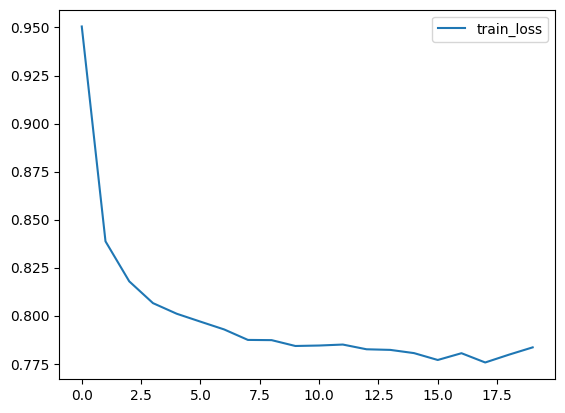

For learning rate =  0.001
Epoch =  0  Train Loss =  0.921373479882955
UAS,LAS =  0.591993711751165 0.5175453371511987
Epoch =  1  Train Loss =  0.6521272087491915
UAS,LAS =  0.631632137443153 0.563640446914828
Epoch =  2  Train Loss =  0.586072983035066
UAS,LAS =  0.6419628319577789 0.5747571725338274
Epoch =  3  Train Loss =  0.5481663384247075
UAS,LAS =  0.650833754421425 0.5834035146819381
Epoch =  4  Train Loss =  0.5226128282077299
UAS,LAS =  0.6547639099432935 0.5859300432317107
Epoch =  5  Train Loss =  0.5033113835620181
UAS,LAS =  0.6581887597552074 0.5890180225703218
Epoch =  6  Train Loss =  0.4881526001953107
UAS,LAS =  0.6592555162540004 0.5903093593846499
Epoch =  7  Train Loss =  0.47599441582377755
UAS,LAS =  0.6623434955926113 0.5930043231710741
Epoch =  8  Train Loss =  0.4658383849534256
UAS,LAS =  0.6605468530683286 0.5904216495424176
Epoch =  9  Train Loss =  0.45718090352278284
UAS,LAS =  0.661052158778283 0.5920498568300488
Epoch =  10  Train Loss =  0.449504827

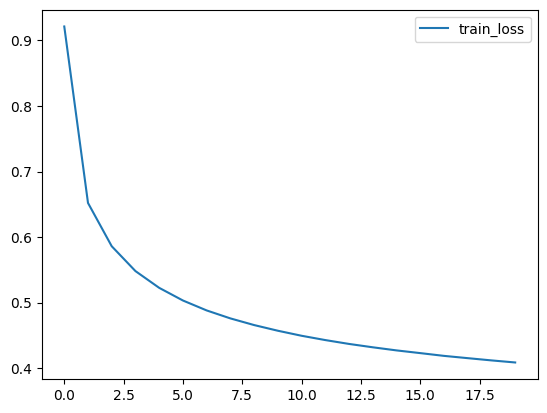

For learning rate =  0.0001
Epoch =  0  Train Loss =  1.6139703615611163
UAS,LAS =  0.3726910336309022 0.272921228454326
Epoch =  1  Train Loss =  1.0897036026829992
UAS,LAS =  0.4634776261860648 0.37415080568188197
Epoch =  2  Train Loss =  0.9432767313455137
UAS,LAS =  0.5211386221997641 0.43877379147717704
Epoch =  3  Train Loss =  0.8623765247761018
UAS,LAS =  0.5525798663747122 0.475717253382741
Epoch =  4  Train Loss =  0.8075992628769064
UAS,LAS =  0.5685812138566054 0.49385211386222
Epoch =  5  Train Loss =  0.7666324702263708
UAS,LAS =  0.5839088203918926 0.5119869743416989
Epoch =  6  Train Loss =  0.7343052286380684
UAS,LAS =  0.5930043231710741 0.5234405704340015
Epoch =  7  Train Loss =  0.708182313036966
UAS,LAS =  0.6018191005558363 0.5328729436864859
Epoch =  8  Train Loss =  0.686766467062723
UAS,LAS =  0.6100162820728763 0.5417438661501319
Epoch =  9  Train Loss =  0.6688200997051673
UAS,LAS =  0.6146201785413509 0.548200550221773
Epoch =  10  Train Loss =  0.65342449

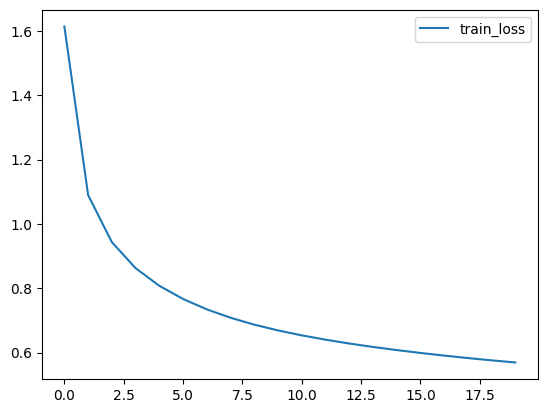

In [ ]:
glv_size = '6B'
glv_dim = 50
mean_mode = 0 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

train_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=False, batch_size=64)

# train_dataloader, dev_dataloader, test_dataloader, glove_embedding_dimension = prepare_dataset(glv_size, glv_dim, mean_mode, cwindow)

learning_rates = np.array([0.01, 0.001, 0.0001])
best_acc = -1

for i in range(learning_rates.shape[0]):
  pos_vocab_size = len(pos_dict)
  pos_embedding_dimension = 50
  # glove_embedding_dimension = X_train.shape[1] - 4
  # print(glove_embedding_dimension)
  hidden_dim = 200
  action_vocab_size = len(targets_dict)
  epoch = 20


  parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
  parser_model.to(device)
  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(parser_model.parameters(), lr=learning_rates[i])
  print("For learning rate = ",learning_rates[i])

  train_losses, ret_model, best_dev_acc = batch_gd(
      parser_model, criterion, optimizer, train_dataloader, dev_w, dev_pos, dev_target, epoch, vec6B50D, glv_size, glv_dim, learning_rates[i], mean_mode)


  # avg_dev_losses = np.mean(dev_losses)
  # print('Best Development Loss = ', best_dev_loss)


  plt.plot(train_losses, label = 'train_loss')
  # plt.plot(dev_losses, label = 'dev_loss')
  plt.legend()
  plt.show()

In [ ]:
pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

Best Dev Accuracy =  0.6492616922126776
Learning Rate =  0.0001
Epoch =  19


Parser_Model(
  (embeddings): Embedding(18, 50, max_norm=1)
  (linear1): Linear(in_features=50, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=75, bias=True)
  (relu): ReLU()
)

##6B300D Mean

In [ ]:
#Set glove and embedding dimenaion
vec = vec6B300D
embed_dim = 300
mean_mode == 1
cwindow = 2

X_train, y_train = prepare_train_corpus(train_w, train_pos, train_target, vec, embed_dim, mean_mode, cwindow)

print(X_train.shape, y_train.shape)

1
torch.Size([257487, 304]) torch.Size([257487])


In [ ]:
glv_size = '6B'
glv_dim = 300
mean_mode = 1 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

train_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=False, batch_size=64)

# train_dataloader, dev_dataloader, test_dataloader, glove_embedding_dimension = prepare_dataset(glv_size, glv_dim, mean_mode, cwindow)

learning_rates = np.array([0.01, 0.001, 0.0001])
best_acc = -1

for i in range(learning_rates.shape[0]):
  pos_vocab_size = len(pos_dict)
  pos_embedding_dimension = 50
  # glove_embedding_dimension = X_train.shape[1] - 4
  # print(glove_embedding_dimension)
  hidden_dim = 200
  action_vocab_size = len(targets_dict)
  epoch = 20

  print(glove_embedding_dimension)
  parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
  parser_model.to(device)
  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(parser_model.parameters(), lr=learning_rates[i])
  print("For learning rate = ",learning_rates[i])

  train_losses, ret_model, best_dev_acc = batch_gd(
      parser_model, criterion, optimizer, train_dataloader, dev_w, dev_pos, dev_target, epoch, vec, glv_size, glv_dim, learning_rates[i], mean_mode)


  # avg_dev_losses = np.mean(dev_losses)
  # print('Best Development Loss = ', best_dev_loss)


  plt.plot(train_losses, label = 'train_loss')
  # plt.plot(dev_losses, label = 'dev_loss')
  plt.legend()
  plt.show()

300
For learning rate =  0.01
Epoch =  0  Train Loss =  1.3745987805913742
UAS,LAS =  0.33698276346078265 0.258548088260064
Epoch =  1  Train Loss =  1.2767245647595606
UAS,LAS =  0.36763797653135705 0.2969513222166077
Epoch =  2  Train Loss =  1.2639385270284373
UAS,LAS =  0.3606198416708776 0.29448093874571896
Epoch =  3  Train Loss =  1.2586416017049349
UAS,LAS =  0.3350176856998484 0.2588288136544832
Epoch =  4  Train Loss =  1.2522699815141516
UAS,LAS =  0.3477064735275953 0.27224748750771993
Epoch =  5  Train Loss =  1.2527568733863992
UAS,LAS =  0.3767334793105384 0.31014541575430915
Epoch =  6  Train Loss =  1.254630109395232
UAS,LAS =  0.356015945202403 0.27932176744708326
Epoch =  7  Train Loss =  1.2549790945311428
UAS,LAS =  0.37263488855201843 0.2929088765369715
Epoch =  8  Train Loss =  1.2509009805961584
UAS,LAS =  0.34781876368536296 0.26893492785357365
Epoch =  9  Train Loss =  1.2520997877756714
UAS,LAS =  0.3615181629330189 0.2847116950199315
Epoch =  10  Train Loss 

In [ ]:
pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

##6B300D Concatenate

In [ ]:
#Set glove and embedding dimenaion
vec = vec6B300D
embed_dim = 300
mean_mode == 0
cwindow = 2

X_train, y_train = prepare_train_corpus(train_w, train_pos, train_target, vec, embed_dim, mean_mode, cwindow)

print(X_train.shape, y_train.shape)

In [ ]:
glv_size = '6B'
glv_dim = 300
mean_mode = 0 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

train_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=False, batch_size=64)

# train_dataloader, dev_dataloader, test_dataloader, glove_embedding_dimension = prepare_dataset(glv_size, glv_dim, mean_mode, cwindow)

learning_rates = np.array([0.01, 0.001, 0.0001])
best_acc = -1

for i in range(learning_rates.shape[0]):
  pos_vocab_size = len(pos_dict)
  pos_embedding_dimension = 50
  # glove_embedding_dimension = X_train.shape[1] - 4
  # print(glove_embedding_dimension)
  hidden_dim = 200
  action_vocab_size = len(targets_dict)
  epoch = 20

  print(glove_embedding_dimension)
  parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
  parser_model.to(device)
  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(parser_model.parameters(), lr=learning_rates[i])
  print("For learning rate = ",learning_rates[i])

  train_losses, ret_model, best_dev_acc = batch_gd(
      parser_model, criterion, optimizer, train_dataloader, dev_w, dev_pos, dev_target, epoch, vec, glv_size, glv_dim, learning_rates[i], mean_mode)


  # avg_dev_losses = np.mean(dev_losses)
  # print('Best Development Loss = ', best_dev_loss)


  plt.plot(train_losses, label = 'train_loss')
  # plt.plot(dev_losses, label = 'dev_loss')
  plt.legend()
  plt.show()

In [ ]:
pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

##42B300D Mean

In [ ]:
#Set glove and embedding dimenaion
vec = vec42B300D
embed_dim = 300
mean_mode == 1
cwindow = 2

X_train, y_train = prepare_train_corpus(train_w, train_pos, train_target, vec, embed_dim, mean_mode, cwindow)

print(X_train.shape, y_train.shape)

In [ ]:
glv_size = '42B'
glv_dim = 300
mean_mode = 1 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

train_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=False, batch_size=64)

# train_dataloader, dev_dataloader, test_dataloader, glove_embedding_dimension = prepare_dataset(glv_size, glv_dim, mean_mode, cwindow)

learning_rates = np.array([0.01, 0.001, 0.0001])
best_acc = -1

for i in range(learning_rates.shape[0]):
  pos_vocab_size = len(pos_dict)
  pos_embedding_dimension = 50
  # glove_embedding_dimension = X_train.shape[1] - 4
  # print(glove_embedding_dimension)
  hidden_dim = 200
  action_vocab_size = len(targets_dict)
  epoch = 20

  print(glove_embedding_dimension)
  parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
  parser_model.to(device)
  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(parser_model.parameters(), lr=learning_rates[i])
  print("For learning rate = ",learning_rates[i])

  train_losses, ret_model, best_dev_acc = batch_gd(
      parser_model, criterion, optimizer, train_dataloader, dev_w, dev_pos, dev_target, epoch, vec, glv_size, glv_dim, learning_rates[i], mean_mode)


  # avg_dev_losses = np.mean(dev_losses)
  # print('Best Development Loss = ', best_dev_loss)


  plt.plot(train_losses, label = 'train_loss')
  # plt.plot(dev_losses, label = 'dev_loss')
  plt.legend()
  plt.show()

In [ ]:
pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

##42B300D Concatenate

In [ ]:
#Set glove and embedding dimenaion
vec = vec42B300D
embed_dim = 300
mean_mode == 0
cwindow = 2

X_train, y_train = prepare_train_corpus(train_w, train_pos, train_target, vec, embed_dim, mean_mode, cwindow)

print(X_train.shape, y_train.shape)

In [ ]:
glv_size = '42B'
glv_dim = 300
mean_mode = 0 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

train_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=False, batch_size=64)

# train_dataloader, dev_dataloader, test_dataloader, glove_embedding_dimension = prepare_dataset(glv_size, glv_dim, mean_mode, cwindow)

learning_rates = np.array([0.01, 0.001, 0.0001])
best_acc = -1

for i in range(learning_rates.shape[0]):
  pos_vocab_size = len(pos_dict)
  pos_embedding_dimension = 50
  # glove_embedding_dimension = X_train.shape[1] - 4
  # print(glove_embedding_dimension)
  hidden_dim = 200
  action_vocab_size = len(targets_dict)
  epoch = 20

  print(glove_embedding_dimension)
  parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
  parser_model.to(device)
  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(parser_model.parameters(), lr=learning_rates[i])
  print("For learning rate = ",learning_rates[i])

  train_losses, ret_model, best_dev_acc = batch_gd(
      parser_model, criterion, optimizer, train_dataloader, dev_w, dev_pos, dev_target, epoch, vec, glv_size, glv_dim, learning_rates[i], mean_mode)


  # avg_dev_losses = np.mean(dev_losses)
  # print('Best Development Loss = ', best_dev_loss)


  plt.plot(train_losses, label = 'train_loss')
  # plt.plot(dev_losses, label = 'dev_loss')
  plt.legend()
  plt.show()

In [ ]:
pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

##840B300D Mean

In [25]:
#Set glove and embedding dimenaion
vec = vec840B300D
embed_dim = 300
mean_mode == 1
cwindow = 2

X_train, y_train = prepare_train_corpus(train_w, train_pos, train_target, vec, embed_dim, mean_mode, cwindow)

print(X_train.shape, y_train.shape)

1
torch.Size([257487, 304]) torch.Size([257487])


300
For learning rate =  0.01
Epoch =  0  Train Loss =  1.2544618472382871
UAS,LAS =  0.23783055415192858 0.15771152658469484
Epoch =  1  Train Loss =  1.1735241547612025
UAS,LAS =  0.2527090000561451 0.16377519510414912
Epoch =  2  Train Loss =  1.159173497152524
UAS,LAS =  0.20908427376340463 0.12632642748863063
Epoch =  3  Train Loss =  1.15282456546459
UAS,LAS =  0.2456908651956656 0.15080568188198304
Epoch =  4  Train Loss =  1.145725923714415
UAS,LAS =  0.23114928976475213 0.13783616865981696
Epoch =  5  Train Loss =  1.1450240833881065
UAS,LAS =  0.21318286452192464 0.12789848969737802
Epoch =  6  Train Loss =  1.1448632154473017
UAS,LAS =  0.22413115490427263 0.1402504070518219
Epoch =  7  Train Loss =  1.145628504995738
UAS,LAS =  0.23025096850261076 0.149458199988771
Epoch =  8  Train Loss =  1.145168952932711
UAS,LAS =  0.1396328111840997 0.1106058054011566
Epoch =  9  Train Loss =  1.1433930638288823
UAS,LAS =  0.22862276121497951 0.14232777497052385
Epoch =  10  Train Loss

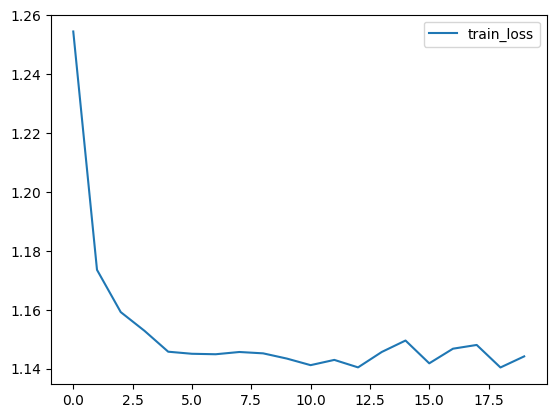

300
For learning rate =  0.001
Epoch =  0  Train Loss =  1.2696509531978704
UAS,LAS =  0.2833080680478356 0.22789287518948964
Epoch =  1  Train Loss =  1.0356136334404558
UAS,LAS =  0.24479254393352423 0.20156083319297063
Epoch =  2  Train Loss =  0.9816563363681375
UAS,LAS =  0.25298972545056425 0.2077367918701926
Epoch =  3  Train Loss =  0.9478227578133167
UAS,LAS =  0.26584694851496266 0.21773061591151535
Epoch =  4  Train Loss =  0.9227711530272695
UAS,LAS =  0.27746897984391666 0.2273314244006513
Epoch =  5  Train Loss =  0.9024387533937546
UAS,LAS =  0.29274044130032 0.235977766548762
Epoch =  6  Train Loss =  0.8859700941282582
UAS,LAS =  0.303688731682668 0.2424344506204031
Epoch =  7  Train Loss =  0.8719467196750564
UAS,LAS =  0.303351861209365 0.24091853349053954
Epoch =  8  Train Loss =  0.8594369034506899
UAS,LAS =  0.3113244624108697 0.24277132109370614
Epoch =  9  Train Loss =  0.8487677845241091
UAS,LAS =  0.318398742350233 0.24816124866655437
Epoch =  10  Train Loss =

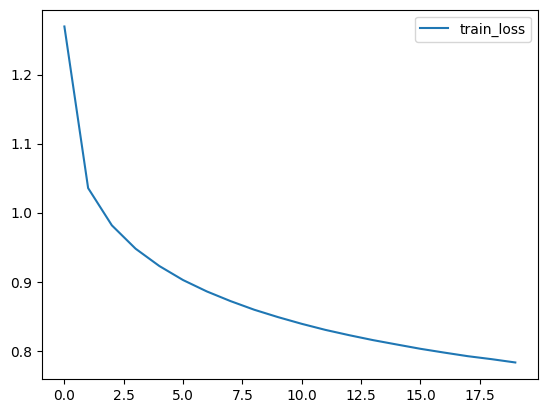

300
For learning rate =  0.0001
Epoch =  0  Train Loss =  1.898432068126813
UAS,LAS =  0.15917129863567459 0.09780472741564201
Epoch =  1  Train Loss =  1.4162983845319472
UAS,LAS =  0.1583852675313009 0.11447981584414126
Epoch =  2  Train Loss =  1.2893407718754313
UAS,LAS =  0.22952108247712089 0.17865364100836562
Epoch =  3  Train Loss =  1.217985937723642
UAS,LAS =  0.30194823423726913 0.2381674246252316
Epoch =  4  Train Loss =  1.1686132903438557
UAS,LAS =  0.31879175790241987 0.2514738083207007
Epoch =  5  Train Loss =  1.132718847557221
UAS,LAS =  0.3263713435517377 0.2572567514457358
Epoch =  6  Train Loss =  1.1055645658514253
UAS,LAS =  0.3263713435517377 0.2571444612879681
Epoch =  7  Train Loss =  1.0841729410777745
UAS,LAS =  0.32704508449834374 0.25860423333894783
Epoch =  8  Train Loss =  1.0666727034326933
UAS,LAS =  0.32216046263545 0.2557408343158722
Epoch =  9  Train Loss =  1.0519038998405217
UAS,LAS =  0.3140194261972938 0.2518106787940037
Epoch =  10  Train Loss 

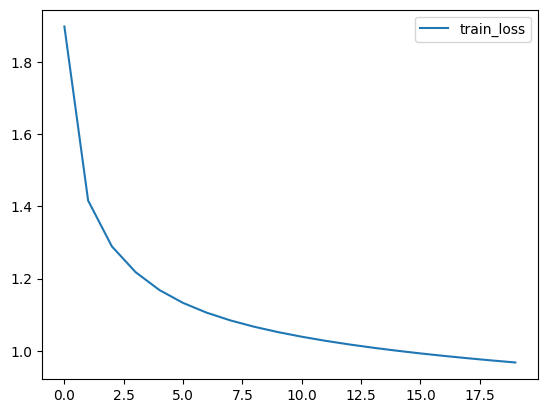

In [26]:
glv_size = '840B'
glv_dim = 300
mean_mode = 1 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

train_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=False, batch_size=64)

# train_dataloader, dev_dataloader, test_dataloader, glove_embedding_dimension = prepare_dataset(glv_size, glv_dim, mean_mode, cwindow)

learning_rates = np.array([0.01, 0.001, 0.0001])
best_acc = -1

for i in range(learning_rates.shape[0]):
  pos_vocab_size = len(pos_dict)
  pos_embedding_dimension = 50
  # glove_embedding_dimension = X_train.shape[1] - 4
  # print(glove_embedding_dimension)
  hidden_dim = 200
  action_vocab_size = len(targets_dict)
  epoch = 20

  print(glove_embedding_dimension)
  parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
  parser_model.to(device)
  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(parser_model.parameters(), lr=learning_rates[i])
  print("For learning rate = ",learning_rates[i])

  train_losses, ret_model, best_dev_acc = batch_gd(
      parser_model, criterion, optimizer, train_dataloader, dev_w, dev_pos, dev_target, epoch, vec, glv_size, glv_dim, learning_rates[i], mean_mode)


  # avg_dev_losses = np.mean(dev_losses)
  # print('Best Development Loss = ', best_dev_loss)


  plt.plot(train_losses, label = 'train_loss')
  # plt.plot(dev_losses, label = 'dev_loss')
  plt.legend()
  plt.show()

In [27]:
pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

Best Dev Accuracy =  0.32704508449834374
Learning Rate =  0.0001
Epoch =  7


Parser_Model(
  (embeddings): Embedding(18, 50, max_norm=1)
  (linear1): Linear(in_features=50, out_features=200, bias=True)
  (linear2): Linear(in_features=300, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=75, bias=True)
  (relu): ReLU()
)

##840B300D Concatenate

In [30]:
#Set glove and embedding dimenaion
vec = vec840B300D
embed_dim = 300
mean_mode == 0
cwindow = 2

X_train, y_train = prepare_train_corpus(train_w, train_pos, train_target, vec, embed_dim, mean_mode, cwindow)

print(X_train.shape, y_train.shape)

0
torch.Size([257487, 1204]) torch.Size([257487])


1200
For learning rate =  0.01
Epoch =  0  Train Loss =  0.8751922457499307
UAS,LAS =  0.5187243838077592 0.44775700409859076
Epoch =  1  Train Loss =  0.7373312681387539
UAS,LAS =  0.5552748301611363 0.48436359553085173
Epoch =  2  Train Loss =  0.7188118689732392
UAS,LAS =  0.5077199483465274 0.45247319072483294
Epoch =  3  Train Loss =  0.7099000053835762
UAS,LAS =  0.5406771096513391 0.46869911852226154
Epoch =  4  Train Loss =  0.6941991744870338
UAS,LAS =  0.537252259839425 0.46735163662904944
Epoch =  5  Train Loss =  0.6883241929943353
UAS,LAS =  0.5479198248273539 0.48279153332210434
Epoch =  6  Train Loss =  0.6762422469924121
UAS,LAS =  0.5357363427095615 0.4713940823086856
Epoch =  7  Train Loss =  0.6740696117278211
UAS,LAS =  0.5371399696816574 0.47453820672618047
Epoch =  8  Train Loss =  0.6754178465186631
UAS,LAS =  0.5263039694570771 0.4582561338498681
Epoch =  9  Train Loss =  0.6683553332596217
UAS,LAS =  0.5307955757677839 0.46701476615574644
Epoch =  10  Train Los

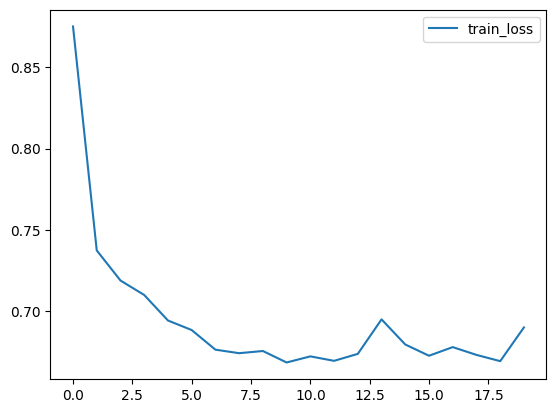

1200
For learning rate =  0.001
Epoch =  0  Train Loss =  0.7147676165828529
UAS,LAS =  0.632362023468643 0.575262478243782
Epoch =  1  Train Loss =  0.4817501494890564
UAS,LAS =  0.6398293189601931 0.5860423333894784
Epoch =  2  Train Loss =  0.4048767307454768
UAS,LAS =  0.6470158890573241 0.5929481780921902
Epoch =  3  Train Loss =  0.34989214202974206
UAS,LAS =  0.651844365841334 0.5976643647184324
Epoch =  4  Train Loss =  0.30614012646975797
UAS,LAS =  0.6530795575767784 0.5980573802706193
Epoch =  5  Train Loss =  0.2703071148009789
UAS,LAS =  0.6493178372915613 0.5932850485654932
Epoch =  6  Train Loss =  0.24021327572691423
UAS,LAS =  0.651170624894728 0.593397338723261
Epoch =  7  Train Loss =  0.21497440176588256
UAS,LAS =  0.6419066868788951 0.5855370276795239
Epoch =  8  Train Loss =  0.19362708899423028
UAS,LAS =  0.643984054797597 0.5846387064173825
Epoch =  9  Train Loss =  0.17676776757826715
UAS,LAS =  0.6476896300039302 0.587558250519342
Epoch =  10  Train Loss =  0.

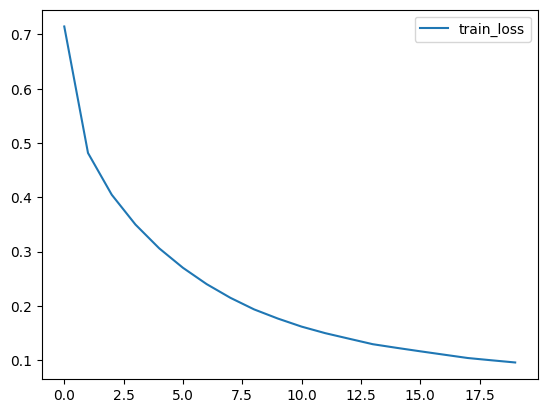

1200
For learning rate =  0.0001
Epoch =  0  Train Loss =  1.2400375044947234
UAS,LAS =  0.4689236988377969 0.41401381168940543
Epoch =  1  Train Loss =  0.7590473014305884
UAS,LAS =  0.5460108921453035 0.49177474594351805
Epoch =  2  Train Loss =  0.6522787034133852
UAS,LAS =  0.5662792656223682 0.5141766324181686
Epoch =  3  Train Loss =  0.5941570305615427
UAS,LAS =  0.580034809948908 0.5275953062714053
Epoch =  4  Train Loss =  0.5543459752911543
UAS,LAS =  0.5903093593846499 0.537982145864915
Epoch =  5  Train Loss =  0.5237648462206421
UAS,LAS =  0.5986749761383414 0.5462916175397227
Epoch =  6  Train Loss =  0.49883074156577084
UAS,LAS =  0.6038964684745383 0.5529167368480152
Epoch =  7  Train Loss =  0.47774436649594226
UAS,LAS =  0.6075458986019875 0.5572399079220707
Epoch =  8  Train Loss =  0.4595215666991016
UAS,LAS =  0.6122620852282298 0.5620122396271967
Epoch =  9  Train Loss =  0.4435158049110064
UAS,LAS =  0.6133849868059065 0.5638650272303632
Epoch =  10  Train Loss =

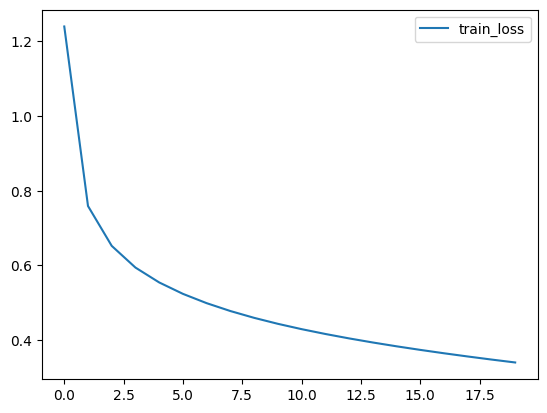

In [31]:
glv_size = '840B'
glv_dim = 300
mean_mode = 0 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

train_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=False, batch_size=64)

# train_dataloader, dev_dataloader, test_dataloader, glove_embedding_dimension = prepare_dataset(glv_size, glv_dim, mean_mode, cwindow)

learning_rates = np.array([0.01, 0.001, 0.0001])
best_acc = -1

for i in range(learning_rates.shape[0]):
  pos_vocab_size = len(pos_dict)
  pos_embedding_dimension = 50
  # glove_embedding_dimension = X_train.shape[1] - 4
  # print(glove_embedding_dimension)
  hidden_dim = 200
  action_vocab_size = len(targets_dict)
  epoch = 20

  print(glove_embedding_dimension)
  parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
  parser_model.to(device)
  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(parser_model.parameters(), lr=learning_rates[i])
  print("For learning rate = ",learning_rates[i])

  train_losses, ret_model, best_dev_acc = batch_gd(
      parser_model, criterion, optimizer, train_dataloader, dev_w, dev_pos, dev_target, epoch, vec, glv_size, glv_dim, learning_rates[i], mean_mode)


  # avg_dev_losses = np.mean(dev_losses)
  # print('Best Development Loss = ', best_dev_loss)


  plt.plot(train_losses, label = 'train_loss')
  # plt.plot(dev_losses, label = 'dev_loss')
  plt.legend()
  plt.show()

In [32]:
pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

Best Dev Accuracy =  0.63202515299534
Learning Rate =  0.0001
Epoch =  18


Parser_Model(
  (embeddings): Embedding(18, 50, max_norm=1)
  (linear1): Linear(in_features=50, out_features=200, bias=True)
  (linear2): Linear(in_features=1200, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=75, bias=True)
  (relu): ReLU()
)

#Task-1)Generating Result.txt

In [52]:
vec = vec42B300D
embed_dim = 300
mean_mode == 0
cwindow = 2

glv_size = '42B'
glv_dim = 300
mean_mode = 0 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)


pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

Best Dev Accuracy =  0.7120880354836898
Learning Rate =  0.0001
Epoch =  18


Parser_Model(
  (embeddings): Embedding(18, 50, max_norm=1)
  (linear1): Linear(in_features=50, out_features=200, bias=True)
  (linear2): Linear(in_features=1200, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=75, bias=True)
  (relu): ReLU()
)

In [53]:
def hidden_samples_write(model, dev_words, dev_pos, glove, glv_size, glv_dim, mean_mode):
  dev_pred_actions = []
  for k in range(len(dev_words)):
    # if k % 5000 == 0:
    #   print("For Data = ", k)
    stack = [Token(idx=-j-1, word="[NULL]", pos= pos_dict['NULL']) for j in range(cwindow)]
    parser_buff = []
    dev_dependencies =[]
    for ix in range(len(dev_words[k])):
      parser_buff.append(Token(idx=ix, word=dev_words[k][ix], pos=dev_pos[k][ix]))
    parser_buff.extend([Token(idx=ix+j+1, word="[NULL]",pos= pos_dict['NULL']) for j in range(cwindow)])
    state = ParseState(stack=stack, parse_buffer=parser_buff, dependencies=[])
    m = 0
    dev_temp_action = []
    while(not is_final_state(state,cwindow)):
      dev_input=[]
      # print("Stack len = :", len(stack), len(parser_buff))
      dev_input.append(stack[-1].word)
      dev_input.append(stack[-2].word)
      dev_input.append(parser_buff[0].word)
      dev_input.append(parser_buff[1].word)
      dev_input.append(stack[-1].pos)
      dev_input.append(stack[-2].pos)
      dev_input.append(parser_buff[0].pos)
      dev_input.append(parser_buff[1].pos)

      temp_emb = glove.get_vecs_by_tokens(dev_input[:4])
      if mean_mode==1:
        temp_emb = torch.mean(temp_emb, dim=0)
      else:
        temp_emb = torch.flatten(temp_emb)
      # print(temp_emb.shape)
      # print(dev_input)
      temp_pos = torch.tensor(dev_input[4:])
      # print(temp_pos.shape)
      # print(temp_emb.shape)
      # print(temp_pos.shape)
      temp_input = torch.cat((temp_emb, temp_pos)).unsqueeze(0).to(device)
      # print(temp_input)
      outputs = model(temp_input)
      # print('Outputs = ',outputs.shape)
      _, predictions = torch.max(outputs, 1)
      # print('predictions = ',predictions)
      pred_action = target_itos(predictions[0])

      if len(stack) == 2 and predictions[0] != 0:
        pred_action = "SHIFT"
      elif len(parser_buff) == 2 and predictions[0] == 0:
        outputs[0][0] = -1000000
        _, predictions = torch.max(outputs, 1)
        pred_action = target_itos(predictions[0])

      # print('predictions = ',pred_action)

      dev_temp_action.append(pred_action)
      if pred_action == "SHIFT":
        shift(state)
      elif pred_action[:8] == "REDUCE_L":
        left_arc(state, pred_action[9:])
      else:
        right_arc(state, pred_action[9:])
    dev_pred_actions.append(dev_temp_action)


  with open('/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/results.txt', 'w') as f:
    for row in dev_pred_actions:
      f.write(" ".join([word for word in row]) + "\n")
  print("Writing in result.txt done")
  # dev_uas, dev_las = compute_metrics(dev_words, dev_actions, dev_pred_actions, cwindow=2)
  # return dev_uas, dev_las

In [54]:
hidden_samples_write(parser_model, hidden_w, hidden_pos, vec, glv_size, glv_dim, mean_mode)
# print("For ",glv_size,glv_dim,"B LAS = ",dev_las, " and UAS = ", dev_uas)

Writing in result.txt done


#Task-2) Provide the results of parser on the test split

##a)6B50D Mean

In [34]:
vec = vec6B50D
embed_dim = 50
mean_mode == 1
cwindow = 2

glv_size = '6B'
glv_dim = 50
mean_mode = 1 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)


pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

Best Dev Accuracy =  0.3952052102633204
Learning Rate =  0.0001
Epoch =  19


Parser_Model(
  (embeddings): Embedding(18, 50, max_norm=1)
  (linear1): Linear(in_features=50, out_features=200, bias=True)
  (linear2): Linear(in_features=50, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=75, bias=True)
  (relu): ReLU()
)

In [35]:
def test_samples(model, dev_words, dev_pos, dev_actions, glove, glv_size, glv_dim, mean_mode):
  dev_pred_actions = []
  for k in range(len(dev_words)):
    # if k % 5000 == 0:
    #   print("For Data = ", k)
    stack = [Token(idx=-j-1, word="[NULL]", pos= pos_dict['NULL']) for j in range(cwindow)]
    parser_buff = []
    dev_dependencies =[]
    for ix in range(len(dev_words[k])):
      parser_buff.append(Token(idx=ix, word=dev_words[k][ix], pos=dev_pos[k][ix]))
    parser_buff.extend([Token(idx=ix+j+1, word="[NULL]",pos= pos_dict['NULL']) for j in range(cwindow)])
    state = ParseState(stack=stack, parse_buffer=parser_buff, dependencies=[])
    m = 0
    dev_temp_action = []
    while(not is_final_state(state,cwindow)):
      dev_input=[]
      # print("Stack len = :", len(stack), len(parser_buff))
      dev_input.append(stack[-1].word)
      dev_input.append(stack[-2].word)
      dev_input.append(parser_buff[0].word)
      dev_input.append(parser_buff[1].word)
      dev_input.append(stack[-1].pos)
      dev_input.append(stack[-2].pos)
      dev_input.append(parser_buff[0].pos)
      dev_input.append(parser_buff[1].pos)

      temp_emb = glove.get_vecs_by_tokens(dev_input[:4])
      if mean_mode==1:
        temp_emb = torch.mean(temp_emb, dim=0)
      else:
        temp_emb = torch.flatten(temp_emb)
      # print(temp_emb.shape)
      # print(dev_input)
      temp_pos = torch.tensor(dev_input[4:])
      # print(temp_pos.shape)
      # print(temp_emb.shape)
      # print(temp_pos.shape)
      temp_input = torch.cat((temp_emb, temp_pos)).unsqueeze(0).to(device)
      # print(temp_input)
      outputs = model(temp_input)
      # print('Outputs = ',outputs.shape)
      _, predictions = torch.max(outputs, 1)
      # print('predictions = ',predictions)
      pred_action = target_itos(predictions[0])

      if len(stack) == 2 and predictions[0] != 0:
        pred_action = "SHIFT"
      elif len(parser_buff) == 2 and predictions[0] == 0:
        outputs[0][0] = -1000000
        _, predictions = torch.max(outputs, 1)
        pred_action = target_itos(predictions[0])

      # print('predictions = ',pred_action)

      dev_temp_action.append(pred_action)
      if pred_action == "SHIFT":
        shift(state)
      elif pred_action[:8] == "REDUCE_L":
        left_arc(state, pred_action[9:])
      else:
        right_arc(state, pred_action[9:])
    dev_pred_actions.append(dev_temp_action)

  dev_uas, dev_las = compute_metrics(dev_words, dev_actions, dev_pred_actions, cwindow=2)
  return dev_uas, dev_las

In [36]:
dev_uas, dev_las = test_samples(parser_model, test_w, test_pos, test_target, vec, glv_size, glv_dim, mean_mode)
print("For ",glv_size,glv_dim,"B LAS = ",dev_las, " and UAS = ", dev_uas)

For  6B 50 B LAS =  0.3054256314312441  and UAS =  0.3697120881405259


##b)6B50D Concatenate

In [38]:
vec = vec6B50D
embed_dim = 50
mean_mode == 0
cwindow = 2

glv_size = '6B'
glv_dim = 50
mean_mode = 0 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)


pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

Best Dev Accuracy =  0.6492616922126776
Learning Rate =  0.0001
Epoch =  19


Parser_Model(
  (embeddings): Embedding(18, 50, max_norm=1)
  (linear1): Linear(in_features=50, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=75, bias=True)
  (relu): ReLU()
)

In [39]:
dev_uas, dev_las = test_samples(parser_model, test_w, test_pos, test_target, vec, glv_size, glv_dim, mean_mode)
print("For ",glv_size,glv_dim,"B LAS = ",dev_las, " and UAS = ", dev_uas)

For  6B 50 B LAS =  0.5590894917368257  and UAS =  0.6240515538925268


##c)6B300D Mean

In [40]:
vec = vec6B300D
embed_dim = 300
mean_mode == 1
cwindow = 2

glv_size = '6B'
glv_dim = 300
mean_mode = 1 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)


pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

Best Dev Accuracy =  0.4247375217562181
Learning Rate =  0.0001
Epoch =  19


Parser_Model(
  (embeddings): Embedding(18, 50, max_norm=1)
  (linear1): Linear(in_features=50, out_features=200, bias=True)
  (linear2): Linear(in_features=300, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=75, bias=True)
  (relu): ReLU()
)

In [41]:
dev_uas, dev_las = test_samples(parser_model, test_w, test_pos, test_target, vec, glv_size, glv_dim, mean_mode)
print("For ",glv_size,glv_dim,"B LAS = ",dev_las, " and UAS = ", dev_uas)

For  6B 300 B LAS =  0.33000727575096145  and UAS =  0.3941897931607941


##d)6B300D Concatenate

In [42]:
vec = vec6B300D
embed_dim = 300
mean_mode == 0
cwindow = 2

glv_size = '6B'
glv_dim = 300
mean_mode = 0 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)


pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

Best Dev Accuracy =  0.6732356408960755
Learning Rate =  0.0001
Epoch =  19


Parser_Model(
  (embeddings): Embedding(18, 50, max_norm=1)
  (linear1): Linear(in_features=50, out_features=200, bias=True)
  (linear2): Linear(in_features=1200, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=75, bias=True)
  (relu): ReLU()
)

In [43]:
dev_uas, dev_las = test_samples(parser_model, test_w, test_pos, test_target, vec, glv_size, glv_dim, mean_mode)
print("For ",glv_size,glv_dim,"B LAS = ",dev_las, " and UAS = ", dev_uas)

For  6B 300 B LAS =  0.5948446107473235  and UAS =  0.656688493919551


##e)42B300D Mean

In [44]:
vec = vec42B300D
embed_dim = 300
mean_mode == 1
cwindow = 2

glv_size = '42B'
glv_dim = 300
mean_mode = 1 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)


pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

Best Dev Accuracy =  0.4431531076301162
Learning Rate =  0.0001
Epoch =  18


Parser_Model(
  (embeddings): Embedding(18, 50, max_norm=1)
  (linear1): Linear(in_features=50, out_features=200, bias=True)
  (linear2): Linear(in_features=300, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=75, bias=True)
  (relu): ReLU()
)

In [45]:
dev_uas, dev_las = test_samples(parser_model, test_w, test_pos, test_target, vec, glv_size, glv_dim, mean_mode)
print("For ",glv_size,glv_dim,"B LAS = ",dev_las, " and UAS = ", dev_uas)

For  42B 300 B LAS =  0.3557322523646191  and UAS =  0.41809583203409206


##f)42B300D Concatenate (Best Score)

In [46]:
vec = vec42B300D
embed_dim = 300
mean_mode == 0
cwindow = 2

glv_size = '42B'
glv_dim = 300
mean_mode = 0 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)


pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

Best Dev Accuracy =  0.7120880354836898
Learning Rate =  0.0001
Epoch =  18


Parser_Model(
  (embeddings): Embedding(18, 50, max_norm=1)
  (linear1): Linear(in_features=50, out_features=200, bias=True)
  (linear2): Linear(in_features=1200, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=75, bias=True)
  (relu): ReLU()
)

In [47]:
dev_uas, dev_las = test_samples(parser_model, test_w, test_pos, test_target, vec, glv_size, glv_dim, mean_mode)
print("For ",glv_size,glv_dim,"B LAS = ",dev_las, " and UAS = ", dev_uas)

For  42B 300 B LAS =  0.6236357966947302  and UAS =  0.6811661989398191


##g)840B300D Mean

In [48]:
vec = vec840B300D
embed_dim = 300
mean_mode = 1
cwindow = 2

glv_size = '840B'
glv_dim = 300
mean_mode = 1 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)


pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

Best Dev Accuracy =  0.32704508449834374
Learning Rate =  0.0001
Epoch =  7


Parser_Model(
  (embeddings): Embedding(18, 50, max_norm=1)
  (linear1): Linear(in_features=50, out_features=200, bias=True)
  (linear2): Linear(in_features=300, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=75, bias=True)
  (relu): ReLU()
)

In [49]:
dev_uas, dev_las = test_samples(parser_model, test_w, test_pos, test_target, vec, glv_size, glv_dim, mean_mode)
print("For ",glv_size,glv_dim,"B LAS = ",dev_las, " and UAS = ", dev_uas)

For  840B 300 B LAS =  0.25402764785365345  and UAS =  0.3184700135121089


##h)840B300D Concatenate

In [50]:
vec = vec840B300D
embed_dim = 300
mean_mode = 0
cwindow = 2

glv_size = '840B'
glv_dim = 300
mean_mode = 0 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)


pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

Best Dev Accuracy =  0.63202515299534
Learning Rate =  0.0001
Epoch =  18


Parser_Model(
  (embeddings): Embedding(18, 50, max_norm=1)
  (linear1): Linear(in_features=50, out_features=200, bias=True)
  (linear2): Linear(in_features=1200, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=75, bias=True)
  (relu): ReLU()
)

In [51]:
dev_uas, dev_las = test_samples(parser_model, test_w, test_pos, test_target, vec, glv_size, glv_dim, mean_mode)
print("For ",glv_size,glv_dim,"B LAS = ",dev_las, " and UAS = ", dev_uas)

For  840B 300 B LAS =  0.5646502442573537  and UAS =  0.611370959359734


#Task-3)Summarizing Trends

#Task-4)Dependency parse trees

##a) Mary had a little lamb . (POS tags: PROPN AUX DET ADJ NOUN PUNCT)

In [55]:
vec = vec42B300D
embed_dim = 300
mean_mode == 0
cwindow = 2

glv_size = '42B'
glv_dim = 300
mean_mode = 0 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)


pos_vocab_size = len(pos_dict)
pos_embedding_dimension = 50
# glove_embedding_dimension = X_train.shape[1] - 4
# print(glove_embedding_dimension)
hidden_dim = 200
action_vocab_size = len(targets_dict)
epoch = 20
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

model_path = f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_{glv_size}_{glv_dim}_{mean_mode}.pth"
checkpoint = torch.load(model_path)
parser_model = Parser_Model(pos_vocab_size, pos_embedding_dimension, glove_embedding_dimension, hidden_dim, action_vocab_size)
optimizer = torch.optim.Adam(parser_model.parameters(), checkpoint["learning_rate"])
parser_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
print("Best Dev Accuracy = ", checkpoint["lowest_dev_loss"])
print("Learning Rate = ", checkpoint["learning_rate"])
print("Epoch = ", checkpoint["epoch"])
parser_model.to(device)

Best Dev Accuracy =  0.7120880354836898
Learning Rate =  0.0001
Epoch =  18


Parser_Model(
  (embeddings): Embedding(18, 50, max_norm=1)
  (linear1): Linear(in_features=50, out_features=200, bias=True)
  (linear2): Linear(in_features=1200, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=75, bias=True)
  (relu): ReLU()
)

In [68]:
def single_samples_write(model, dev_words, dev_pos, glove, glv_size, glv_dim, mean_mode):
  dev_pred_actions = []
  all_deps = []
  # print(dev_words)
  for k in range(len(dev_words)):
    # if k % 5000 == 0:
    #   print("For Data = ", k)

    stack = [Token(idx=-j-1, word="[NULL]", pos= pos_dict['NULL']) for j in range(cwindow)]
    parser_buff = []
    dev_dependencies =[]
    for ix in range(len(dev_words[k])):
      parser_buff.append(Token(idx=ix, word=dev_words[k][ix], pos=pos_dict[dev_pos[k][ix]]))
    parser_buff.extend([Token(idx=ix+j+1, word="[NULL]",pos= pos_dict['NULL']) for j in range(cwindow)])
    state = ParseState(stack=stack, parse_buffer=parser_buff, dependencies=[])
    m = 0
    dev_temp_action = []
    # print(len(stack))
    # print(len(parser_buff))
    while(not is_final_state(state,cwindow)):
      dev_input=[]
      # print("Stack len = :", len(stack), len(parser_buff))
      dev_input.append(stack[-1].word)
      dev_input.append(stack[-2].word)
      dev_input.append(parser_buff[0].word)
      dev_input.append(parser_buff[1].word)
      dev_input.append(stack[-1].pos)
      dev_input.append(stack[-2].pos)
      dev_input.append(parser_buff[0].pos)
      dev_input.append(parser_buff[1].pos)

      temp_emb = glove.get_vecs_by_tokens(dev_input[:4])
      if mean_mode==1:
        temp_emb = torch.mean(temp_emb, dim=0)
      else:
        temp_emb = torch.flatten(temp_emb)
      # print(temp_emb.shape)
      # print(dev_input)
      temp_pos = torch.tensor(dev_input[4:])
      # print(temp_pos.shape)
      # print(temp_emb.shape)
      # print(temp_pos.shape)
      temp_input = torch.cat((temp_emb, temp_pos)).unsqueeze(0).to(device)
      # print(temp_input)
      outputs = model(temp_input)
      # print('Outputs = ',outputs.shape)
      _, predictions = torch.max(outputs, 1)
      # print('predictions = ',predictions)
      pred_action = target_itos(predictions[0])

      if len(stack) == 2 and predictions[0] != 0:
        pred_action = "SHIFT"
      elif len(parser_buff) == 2 and predictions[0] == 0:
        outputs[0][0] = -1000000
        _, predictions = torch.max(outputs, 1)
        pred_action = target_itos(predictions[0])

      # print('predictions = ',pred_action)

      dev_temp_action.append(pred_action)
      if pred_action == "SHIFT":
        shift(state)
      elif pred_action[:8] == "REDUCE_L":
        left_arc(state, pred_action[9:])
      else:
        right_arc(state, pred_action[9:])

    right_arc(state, "root")
    all_deps.append(state.dependencies.copy())

    dev_pred_actions.append(dev_temp_action)

  return all_deps, dev_pred_actions



  # dev_uas, dev_las = compute_metrics(dev_words, dev_actions, dev_pred_actions, cwindow=2)
  # return dev_uas, dev_las

In [79]:
single_w = [['Mary', 'had', 'a', 'little', 'lamb', '.']]
single_pos = [['PROPN', 'AUX', 'DET', 'ADJ', 'NOUN', 'PUNCT']]
all_deps, dev_pred_actions = single_samples_write(parser_model, single_w, single_pos, vec, glv_size, glv_dim, mean_mode)
# print(all_deps)
print("All Dependencies")
# DependencyEdge d = new DependencyEdge()
for d in all_deps[0]:
  print(d.label,"(",d.source.word, d.target.word,")")

print("All Actions")
print(dev_pred_actions)

All Dependencies
amod ( lamb little )
det ( lamb a )
aux ( lamb had )
compound ( lamb Mary )
punct ( lamb . )
root ( [NULL] lamb )
All Actions
[['SHIFT', 'SHIFT', 'SHIFT', 'SHIFT', 'SHIFT', 'REDUCE_L_amod', 'REDUCE_L_det', 'REDUCE_L_aux', 'REDUCE_L_compound', 'SHIFT', 'REDUCE_R_punct']]


##b)I ate the fish raw . (POS tags: PRON VERB DET NOUN ADJ PUNCT)

In [80]:
single_w = [['I', 'ate', 'the', 'fish', 'raw', '.']]
single_pos = [['PRON', 'VERB', 'DET', 'NOUN', 'ADJ', 'PUNCT']]
all_deps, dev_pred_actions = single_samples_write(parser_model, single_w, single_pos, vec, glv_size, glv_dim, mean_mode)
# print(all_deps)
print("All Dependencies")
# DependencyEdge d = new DependencyEdge()
for d in all_deps[0]:
  print(d.label,"(",d.source.word, d.target.word,")")

print("All Actions")
print(dev_pred_actions)

All Dependencies
nsubj ( ate I )
det ( fish the )
nsubj ( raw fish )
advcl ( ate raw )
punct ( ate . )
root ( [NULL] ate )
All Actions
[['SHIFT', 'SHIFT', 'REDUCE_L_nsubj', 'SHIFT', 'SHIFT', 'REDUCE_L_det', 'SHIFT', 'REDUCE_L_nsubj', 'REDUCE_R_advcl', 'SHIFT', 'REDUCE_R_punct']]


##c)With neural networks , I love solving problems . (POS tags: ADP ADJ NOUN PUNCT PRON VERB VERB NOUN PUNCT)

In [81]:
single_w = [['With', 'neural', 'networks', ',', 'I', 'love', 'solving', 'problems', '.']]
single_pos = [['ADP', 'ADJ', 'NOUN', 'PUNCT', 'PRON', 'VERB', 'VERB', 'NOUN', 'PUNCT']]
all_deps, dev_pred_actions = single_samples_write(parser_model, single_w, single_pos, vec, glv_size, glv_dim, mean_mode)
# print(all_deps)
print("All Dependencies")
# DependencyEdge d = new DependencyEdge()
for d in all_deps[0]:
  print(d.label,"(",d.source.word, d.target.word,")")

print("All Actions")
print(dev_pred_actions)

All Dependencies
amod ( networks neural )
punct ( networks , )
obj ( solving problems )
advcl ( love solving )
punct ( love . )
obj ( I love )
appos ( networks I )
nmod ( With networks )
root ( [NULL] With )
All Actions
[['SHIFT', 'SHIFT', 'SHIFT', 'REDUCE_L_amod', 'SHIFT', 'REDUCE_R_punct', 'SHIFT', 'SHIFT', 'SHIFT', 'SHIFT', 'REDUCE_R_obj', 'REDUCE_R_advcl', 'SHIFT', 'REDUCE_R_punct', 'REDUCE_R_obj', 'REDUCE_R_appos', 'REDUCE_R_nmod']]


#Extra Credit Task

In [23]:
def convert(lst):
   res_dict = {}
   for i in range(0, len(lst)):
       res_dict[lst[i]] = i
   return res_dict

In [24]:
targets_file = '/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/mp2_release/data/tagset.txt'

file1 = open(targets_file, 'r')
Lines = file1.readlines()
all_actions = []
for line in Lines:
  line1 = line.strip()
  all_actions.append(line1)

list_label=[]
for i in range(1,len(all_actions),2):
  list_label.append(all_actions[i][9:])
# print(len(list_label))
list_label.append('NULL')
label_dic = convert(list_label)
print(label_dic)

{'nsubj': 0, 'obj': 1, 'iobj': 2, 'csubj': 3, 'ccomp': 4, 'xcomp': 5, 'obl': 6, 'vocative': 7, 'expl': 8, 'dislocated': 9, 'advcl': 10, 'advmod': 11, 'discourse': 12, 'aux': 13, 'cop': 14, 'mark': 15, 'nmod': 16, 'appos': 17, 'nummod': 18, 'acl': 19, 'amod': 20, 'det': 21, 'clf': 22, 'case': 23, 'conj': 24, 'cc': 25, 'fixed': 26, 'flat': 27, 'compound': 28, 'list': 29, 'parataxis': 30, 'orphan': 31, 'goeswith': 32, 'reparandum': 33, 'punct': 34, 'root': 35, 'dep': 36, 'NULL': 37}


In [41]:
def extra_embed_to_glove(train_w, vec, embed_dim,  mean, cwindow):
  # print(train_w[0])
  glove = vec
  embedded_text = torch.zeros((len(train_w), (4 * cwindow), embed_dim))
  for i in range(0,len(train_w)):
    # print(len(train_w[i]))
    temp_emb = glove.get_vecs_by_tokens(train_w[i])
    # print(temp_emb.shape)
    embedded_text[i] = temp_emb

    # if(i%10000 == 0):
    #   print(i)
  if mean==1:
    embedded_text = torch.mean(embedded_text, dim=1)
  else:
    embedded_text = embedded_text.view(embedded_text.size()[0], -1)

  print(embedded_text.shape)

  return embedded_text


In [42]:
def extra_prepare_train_corpus(list_words, list_pos, list_action, vec, embed_dim, mean_mode, cwindow):
  all_words = []
  all_pos = []
  all_lr_label=[]
  all_target = []

  for x in range(len(list_words)):
    line_words = list_words[x]
    line_pos = list_pos[x]
    line_action = list_action[x]
    stack = [Token(idx=-i-1, word="[NULL]", pos='NULL') for i in range(cwindow)]
    parser_buff = []
    for ix in range(len(line_words)):
      parser_buff.append(Token(idx=ix, word=line_words[ix], pos=line_pos[ix]))
    parser_buff.extend([Token(idx=ix+i+1, word='NULL',pos="NULL") for i in range(cwindow)])
    state = ParseState(stack=stack, parse_buffer=parser_buff, dependencies=[])
    m = 0
    for action in line_action:
      temp_lr = []
      temp_lr_lab = []
      final_lr_lab = []
      temp_word = [state.stack[-i-1].word for i in range(cwindow)]
      # print(state.dependencies)
      if m==0:
        while len(temp_lr)<2:
          temp_lr.append('NULL')
          temp_lr_lab.append('NULL')
        temp_word.append(temp_lr[0])
        temp_word.append(temp_lr[-1])
        final_lr_lab.append(label_dic[temp_lr_lab[0]])
        final_lr_lab.append(label_dic[temp_lr_lab[1]])
        while len(temp_lr)<2:
          temp_lr.append('NULL')
          temp_lr_lab.append('NULL')
        temp_word.append(temp_lr[0])
        temp_word.append(temp_lr[-1])
        final_lr_lab.append(label_dic[temp_lr_lab[0]])
        final_lr_lab.append(label_dic[temp_lr_lab[1]])
      else:
        for d in state.dependencies:
          if d.source.word == temp_word[0]:
            temp_lr.append(d.target.word)
            temp_lr_lab.append(d.label)
        while len(temp_lr)<2:
          temp_lr.append('NULL')
          temp_lr_lab.append('NULL')
        temp_word.append(temp_lr[0])
        temp_word.append(temp_lr[-1])
        final_lr_lab.append(label_dic[temp_lr_lab[0]])
        final_lr_lab.append(label_dic[temp_lr_lab[1]])

        temp_lr = []
        temp_lr_lab = []
        # final_lr_lab = []
        for d in state.dependencies:
          if d.source.word == temp_word[1]:
            temp_lr.append(d.target.word)
            temp_lr_lab.append(d.label)
        while len(temp_lr)<2:
          temp_lr.append('NULL')
          temp_lr_lab.append('NULL')
        temp_word.append(temp_lr[0])
        temp_word.append(temp_lr[-1])
        final_lr_lab.append(label_dic[temp_lr_lab[0]])
        final_lr_lab.append(label_dic[temp_lr_lab[1]])

        temp_pos = [state.stack[-i-1].pos for i in range(cwindow)]

        temp_word.extend([state.parse_buffer[i].word for i in range(cwindow)])
        temp_pos.extend([state.parse_buffer[i].pos for i in range(cwindow)])

        all_words.append(temp_word)
        all_pos.append(temp_pos)
        all_target.append(action)
        all_lr_label.append(final_lr_lab)

      if action == "SHIFT":
        shift(state)
      elif action[:8] == "REDUCE_L":
        left_arc(state, action[9:])
      else:
        right_arc(state, action[9:])
      m = m+1
  # print(len(all_words[0]))
  # print(len(all_words),len(len(all_words[0])))
  X_train = torch.cat((extra_embed_to_glove(all_words, vec, embed_dim, mean_mode, cwindow),torch.tensor(convert_pos_to_token(all_pos, pos_dict)),torch.tensor(all_lr_label) ), -1)
  y_train = torch.tensor(convert_target_to_token(all_target, targets_dict))

  return X_train, y_train


In [43]:
# Set glove and embedding dimenaion
vec = vec6B50D
embed_dim = 50
mean_mode = 1
cwindow = 2

In [44]:
X_train, y_train = extra_prepare_train_corpus(train_w, train_pos, train_target, vec, embed_dim, mean_mode, cwindow)

torch.Size([249682, 50])


In [45]:
print(X_train.shape)

torch.Size([249682, 58])


In [49]:
class Parser_Model_Extra(nn.Module):
  def __init__(self, pos_vocab_size, pos_embedding_dimension, label_vocab_size, label_embed, glove_embedding_dimension, hidden_dim, action_vocab_size):
    # , embed_max_norm
    super(Parser_Model_Extra, self).__init__()
    self.embeddings = nn.Embedding(
        num_embeddings= pos_vocab_size,
        embedding_dim= pos_embedding_dimension,
        max_norm= 1,
        )
    self.embeddings2 = nn.Embedding(
        num_embeddings= label_vocab_size,
        embedding_dim= label_embed,
        max_norm= 1,
        )
    self.linear1 = nn.Linear(
        in_features= pos_embedding_dimension,
        out_features= hidden_dim,
        )
    self.linear11 = nn.Linear(
        in_features= label_embed,
        out_features= hidden_dim,
        )
    self.linear2 = nn.Linear(
        in_features= glove_embedding_dimension,
        out_features= hidden_dim,
        )
    self.linear3 = nn.Linear(
        in_features= hidden_dim,
        out_features= action_vocab_size,
        )
    self.relu = torch.nn.ReLU()
  def forward(self, inputs_):
    x_w = inputs_[:,:-8]
    x_pos = inputs_[:,-8:-4].to(torch.int32)
    x_label = inputs_[:,-4:].to(torch.int32)
    x_pos = self.embeddings(x_pos)
    x_pos = torch.mean(x_pos, dim=1)
    x_label = self.embeddings2(x_label)
    x_label = torch.mean(x_label, dim=1)
    x1 = self.linear1(x_pos)
    x11 = self.linear11(x_label)
    x2 = self.linear2(x_w)
    x2 = x2 + x1 + x11
    x = self.linear3(self.relu(x2))
    return x

In [75]:
def batch_gd_extra(model, criterion, optimizer, train_loader, dev_words, dev_pos, dev_actions, epochs, glove, glv_size, glv_dim, lr, mean_mode):
  train_losses = np.zeros(epochs)
  # dev_losses = np.zeros(epochs)
  best_acc = -1
  for i in range(epochs):
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      # outputs = outputs.to('cpu')
      # outputs = outputs.detach().numpy()
      # outputs = np.argmax(outputs, axis = 1)
      # print("outputs=",outputs)
      # print("Targets=",targets)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    train_losses[i] = train_loss
    print('Epoch = ', i, ' Train Loss = ',train_loss)

    dev_pred_actions = []
    m = 0
    for k in range(len(dev_words)):
      # if k % 5000 == 0:
      #   print("For Data = ", k)

      stack = [Token(idx=-j-1, word="[NULL]", pos= pos_dict['NULL']) for j in range(cwindow)]
      parser_buff = []
      dev_dependencies =[]
      for ix in range(len(dev_words[k])):
        parser_buff.append(Token(idx=ix, word=dev_words[k][ix], pos=dev_pos[k][ix]))
      parser_buff.extend([Token(idx=ix+j+1, word="[NULL]",pos= pos_dict['NULL']) for j in range(cwindow)])
      state = ParseState(stack=stack, parse_buffer=parser_buff, dependencies=[])
      m = 0
      dev_temp_action = []
      while(not is_final_state(state,cwindow)):
        temp_lr = []
        temp_lr_lab = []
        final_lr_lab = []
        dev_input=[]
        # print("Stack len = :", len(stack), len(parser_buff))
        dev_input.append(stack[-1].word)
        dev_input.append(stack[-2].word)

        if m==0:
          while len(temp_lr)<2:
            temp_lr.append('NULL')
            temp_lr_lab.append('NULL')
          dev_input.append(temp_lr[0])
          dev_input.append(temp_lr[-1])
          final_lr_lab.append(label_dic[temp_lr_lab[0]])
          final_lr_lab.append(label_dic[temp_lr_lab[1]])
          while len(temp_lr)<2:
            temp_lr.append('NULL')
            temp_lr_lab.append('NULL')
          dev_input.append(temp_lr[0])
          dev_input.append(temp_lr[-1])
          final_lr_lab.append(label_dic[temp_lr_lab[0]])
          final_lr_lab.append(label_dic[temp_lr_lab[1]])
        else:
          for d in state.dependencies:
            if d.source.word == dev_input[0]:
              temp_lr.append(d.target.word)
              temp_lr_lab.append(d.label)
          while len(temp_lr)<2:
            temp_lr.append('NULL')
            temp_lr_lab.append('NULL')
          dev_input.append(temp_lr[0])
          dev_input.append(temp_lr[-1])
          final_lr_lab.append(label_dic[temp_lr_lab[0]])
          final_lr_lab.append(label_dic[temp_lr_lab[1]])

          temp_lr = []
          temp_lr_lab = []
          # final_lr_lab = []
          for d in state.dependencies:
            if d.source.word == dev_input[1]:
              temp_lr.append(d.target.word)
              temp_lr_lab.append(d.label)
          while len(temp_lr)<2:
            temp_lr.append('NULL')
            temp_lr_lab.append('NULL')
          dev_input.append(temp_lr[0])
          dev_input.append(temp_lr[-1])
          final_lr_lab.append(label_dic[temp_lr_lab[0]])
          final_lr_lab.append(label_dic[temp_lr_lab[1]])




        dev_input.append(parser_buff[0].word)
        dev_input.append(parser_buff[1].word)
        dev_input.append(stack[-1].pos)
        dev_input.append(stack[-2].pos)
        dev_input.append(parser_buff[0].pos)
        dev_input.append(parser_buff[1].pos)

        temp_emb = glove.get_vecs_by_tokens(dev_input[:8])
        if mean_mode==1:
          temp_emb = torch.mean(temp_emb, dim=0)
        else:
          temp_emb = torch.flatten(temp_emb)
        # print(temp_emb.shape)
        # print(dev_input)
        temp_pos = torch.tensor(dev_input[8:])
        # print(temp_pos.shape)
        # print(temp_emb.shape)
        # print(temp_pos.shape)
        # print(temp_emb.shape, temp_pos.shape, torch.tensor(final_lr_lab).shape)
        # print(temp_emb)
        # temp_input = torch.cat(temp_emb, temp_pos)
        # print(temp_input.shape)
        temp_input = temp_emb.tolist() + temp_pos.tolist() + final_lr_lab
        temp_input = torch.tensor(temp_input).unsqueeze(0).to(device)
        # temp_input = torch.cat(temp_emb, temp_pos, torch.tensor(final_lr_lab)).unsqueeze(0).to(device)
        # print(temp_input)
        outputs = model(temp_input)
        # print('Outputs = ',outputs.shape)
        _, predictions = torch.max(outputs, 1)
        # print('predictions = ',predictions)
        pred_action = target_itos(predictions[0])

        if len(stack) == 2 and predictions[0] != 0:
          pred_action = "SHIFT"
        elif len(parser_buff) == 2 and predictions[0] == 0:
          outputs[0][0] = -1000000
          _, predictions = torch.max(outputs, 1)
          pred_action = target_itos(predictions[0])

        # print('predictions = ',pred_action)

        dev_temp_action.append(pred_action)
        if pred_action == "SHIFT":
          shift(state)
        elif pred_action[:8] == "REDUCE_L":
          left_arc(state, pred_action[9:])
        else:
          right_arc(state, pred_action[9:])
        m = m+1
      dev_pred_actions.append(dev_temp_action)

    # print(dev_words.shape, dev)
    dev_uas, dev_las = compute_metrics(dev_words, dev_actions, dev_pred_actions, cwindow=2)
    print("UAS,LAS = ",dev_uas, dev_las)
    if dev_uas > best_acc:
      best_acc = dev_uas
      torch.save({
          "model_param": model.state_dict(),
          "optim_param": optimizer.state_dict(),
          "lowest_dev_loss": best_acc,
          "epoch": i,
          "learning_rate": lr},
                 f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-2/best_model_extra_{glv_size}_{glv_dim}_{mean_mode}.pth")

  print("Best dev acc = ", best_acc)
  return train_losses, model, best_acc


For learning rate =  0.0001
Epoch =  0  Train Loss =  1.971788707419825
UAS,LAS =  0.1840997136600977 0.11161641682106563
Epoch =  1  Train Loss =  1.4563852711740608
UAS,LAS =  0.24007635730728202 0.16585256302285104
Epoch =  2  Train Loss =  1.3111554381787502
UAS,LAS =  0.26955252372129584 0.20156083319297063
Epoch =  3  Train Loss =  1.232185297642287
UAS,LAS =  0.28240974678569425 0.22020099938240414
Epoch =  4  Train Loss =  1.1791510148454116
UAS,LAS =  0.2905507832238504 0.22912806692493404
Epoch =  5  Train Loss =  1.1398652074490982
UAS,LAS =  0.3017236539217338 0.24002021222839817
Epoch =  6  Train Loss =  1.108849560279592
UAS,LAS =  0.30784346752007186 0.24608388074785245
Epoch =  7  Train Loss =  1.0834256161304086
UAS,LAS =  0.3131772500140363 0.2499017461119533
Epoch =  8  Train Loss =  1.062226359933416
UAS,LAS =  0.3257537476840155 0.2615799225197911
Epoch =  9  Train Loss =  1.044166314592733
UAS,LAS =  0.3367581831452473 0.2723036325866038
Epoch =  10  Train Loss = 

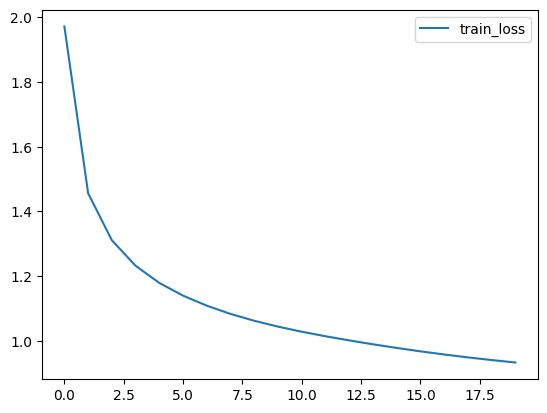

In [76]:
glv_size = '6B'
glv_dim = 50
mean_mode = 1 #If mean then 1
cwindow = 2
glove_embedding_dimension = glv_dim
if mean_mode == 0:
  glove_embedding_dimension = glove_embedding_dimension * ( 2 * cwindow)

train_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=False, batch_size=64)

# train_dataloader, dev_dataloader, test_dataloader, glove_embedding_dimension = prepare_dataset(glv_size, glv_dim, mean_mode, cwindow)

learning_rates = np.array([0.0001])
best_acc = -1

for i in range(learning_rates.shape[0]):
  pos_vocab_size = len(pos_dict)
  pos_embedding_dimension = 50
  # glove_embedding_dimension = X_train.shape[1] - 4
  # print(glove_embedding_dimension)
  hidden_dim = 200
  action_vocab_size = len(targets_dict)
  epoch = 20
  label_vocab_size = len(label_dic)
  label_embed = 50
# pos_vocab_size, pos_embedding_dimension, label_vocab_size, label_embed, glove_embedding_dimension, hidden_dim, action_vocab_size

  parser_model = Parser_Model_Extra(pos_vocab_size, pos_embedding_dimension, label_vocab_size, label_embed, glove_embedding_dimension, hidden_dim, action_vocab_size)
  parser_model.to(device)
  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(parser_model.parameters(), lr=learning_rates[i])
  print("For learning rate = ",learning_rates[i])

  train_losses, ret_model, best_dev_acc = batch_gd_extra(
      parser_model, criterion, optimizer, train_dataloader, dev_w, dev_pos, dev_target, epoch, vec6B50D, glv_size, glv_dim, learning_rates[i], mean_mode)


  # avg_dev_losses = np.mean(dev_losses)
  # print('Best Development Loss = ', best_dev_loss)


  plt.plot(train_losses, label = 'train_loss')
  # plt.plot(dev_losses, label = 'dev_loss')
  plt.legend()
  plt.show()